In [9]:
import pandas as pd

# Read the dataset
df = pd.read_excel("/kaggle/input/syntheticdataset/RWHs_All_Users_Synthetic_Diary (1).xlsx")

# Print column names to verify what is available
print("Columns in the dataset:", df.columns.tolist())


# Define the required columns (update these based on the printed output)
required_columns = ["Distance to Work Location (km)", "Commute Mode", "Work Location Latitude", "Work Location Longitude"]


# Check if the required columns exist
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise KeyError(f"Missing required columns: {missing_columns}")

# Drop records with missing values in the specified columns
df_clean = df.dropna(subset=required_columns)
print("Cleaned data shape:", df_clean.shape)


Columns in the dataset: ['Node ID', 'User Tag', 'Occupation', 'Date Tag', 'Day of Week', 'Weather', 'Residential Address Latitude', 'Residential Address Longitude', 'Work Location', 'Work Location Latitude', 'Work Location Longitude', 'Commute Mode', 'Distance to Work Location (km)', 'Hub Facilities', 'Nearby Amenities Interaction', 'Lunch Location', 'Mood or Sentiment Attribute', 'Social Interaction Level', 'Special Events or Occasions', 'External Influences', 'Personal Growth Activities']
Cleaned data shape: (1687, 21)


CO₂ Emission statistics:
count    1687.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: CO2_emission, dtype: float64
Number of clusters (work hubs): 17
Number of noise points: 51


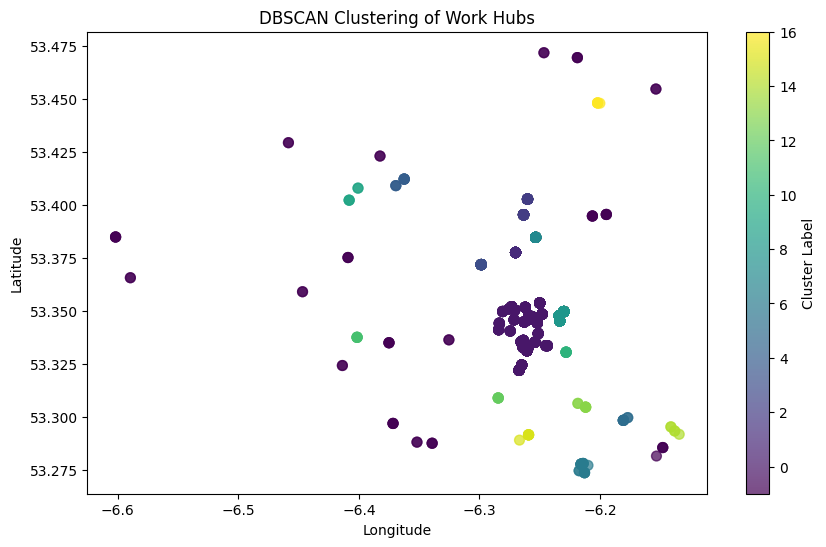

In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Assuming df_clean has already been created from your previous code
# and contains the columns: 'commute_distance', 'travel_mode', 'latitude', 'longitude'

# -----------------------------------------------
# 1. Feature Engineering: Compute CO₂ Emissions
# -----------------------------------------------

# Define emission factors in kg/km for various travel modes
emission_factors = {
    "Car": 0.271,
    "Bus": 0.089,
    "Train": 0.041,
    "Walking": 0,
    "Biking": 0
}

# Function to compute CO₂ emission per record
def compute_emission(row):
    mode = row["Commute Mode"]
    distance = row["Distance to Work Location (km)"]
    factor = emission_factors.get(mode, 0)  # Default to 0 if mode not found
    return distance * factor

# Create a new column 'CO2_emission' by applying the function row-wise
df_clean["CO2_emission"] = df_clean.apply(compute_emission, axis=1)

# Print summary of CO2_emission to verify
print("CO₂ Emission statistics:")
print(df_clean["CO2_emission"].describe())

# -------------------------------------------------
# 2. Clustering: Identifying Work Hubs using DBSCAN
# -------------------------------------------------

# Extract geographic coordinates (latitude and longitude)
coords = df_clean[["Work Location Latitude", "Work Location Longitude"]].values

# Initialize DBSCAN
# Adjust 'eps' (radius in which to search for neighbors) and 'min_samples' according to your data
dbscan = DBSCAN(eps=0.01, min_samples=5)
clusters = dbscan.fit_predict(coords)

# Add cluster labels to the dataframe (-1 indicates noise)
df_clean["cluster"] = clusters

# Report clustering results
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)
print("Number of clusters (work hubs):", n_clusters)
print("Number of noise points:", n_noise)

# -----------------------------------------------
# 3. Optional: Visualizing the Clusters
# -----------------------------------------------

plt.figure(figsize=(10, 6))
plt.scatter(df_clean["Work Location Longitude"], df_clean["Work Location Latitude"], c=df_clean["cluster"], cmap="viridis", s=50, alpha=0.7)
plt.title("DBSCAN Clustering of Work Hubs")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Cluster Label")
plt.show()
